In [1]:
%matplotlib widget
#note: you need to change widget to notebook if you're on jupyter notebook.
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

In [2]:
def vectorfield(w, t, p):
    """
    used for scipy's odeint function, this defines the vector field given some parameters.
    Arguments:
        w :  vector of the state variables:
                  w0 = [θ, x1, φ, x2, ψ, x3]
        t :  time
        p :  vector of the parameters:
                  p = [p2, g2, g3]
    """
    θ, x1, φ, x2, ψ, x3 = w
    p2, g2, g3 = p

    # this is just the system of DEs found from the Euler-Lagrange Equations
    f = [x1,
         (p2*g2*x2**2*np.sin(φ-θ)+p2*x1**2*np.sin(2*(φ-θ))/2+p2*np.sin(φ)*np.cos(φ-θ)-np.sin(θ)) / (1-p2*np.cos(φ-θ)**2),
         x2,
         (x1**2*np.sin(φ-θ)+p2*g2*x2**2*np.sin(2*(φ-θ))/2-np.sin(θ)*np.cos(φ-θ)+np.sin(φ)) / (p2*g2*np.cos(φ-θ)**2-g2),
         x3,
         -np.sin(ψ)/g3]
    return f

def sim(ICsArray, paramArray, stoptime=10.0, numpoints=250):
    # Use ODEINT to solve the differential equations defined by the vector field
    """
    This is the function to use if you want to run a simulation of our double pendulum + single
    pendulum system! You input the initial conditions and parameters you desire, how long + how
    many points to simulate, and it simulates using scipy.integrate's odeint funtcion.
    
    input format:
    ICsArray = [θ, x1, φ, x2, ψ, x3]
    θ_ are the initial angles; x_ are the initial nondiminsionalized angular velocities
    
    paramArray = [p2, g2, g3]
    p2 = "p2"/(1+"p2") = m2/(m1+m2); "p2" = m2/m1; g2=l2/l1; g3=l3/l1
    
    output format:
    wsol, t, ICsArray, paramArray
    
    example call:
    wsol, t, *x = sim([.51,0,1.75,0,1,0], [.5,1,1], stoptime=100.0, numpoints = 1000)
    θ, ψ = wsol[:,0], wsol[:,4]
    f, a = plt.subplots()
    plt.plot(θ,ψ)
    """
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    
    # Create the time samples for the output of the ODE solver.
    # I use a large number of points, only because I want to make
    # a plot of the solution that looks nice.
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

    # Call the ODE solver.
    wsol = odeint(vectorfield, ICsArray, t, args=(paramArray,), atol=abserr, rtol=relerr)
    return wsol, t, ICsArray, paramArray

#makes a simple plot of wsol and t
def θtPlot(wsol, t, showθ=True, showφ=True, showψ=True):
    """
    given the outputs of the sim function, makes a simple plot of θ, φ, and ψ vs t
    """
    θ = wsol[:,0]
    x1 = wsol[:,1]
    φ = wsol[:,2]
    x2 = wsol[:,3]
    ψ = wsol[:,4]
    x3 = wsol[:,5]
    
    lw = 1
    
    [fig, ax] = plt.subplots(1)
    
    if showθ: ax.plot(t, θ, 'b', linewidth=lw)
    if showφ: ax.plot(t, φ, 'g', linewidth=lw)
    if showψ: ax.plot(t, ψ, 'r', linewidth=lw)
    
    ax.set_title('θ, φ, ψ vs tau');
    ax.set(xlabel=r'$t$', ylabel=r'$θ$')
    
    fig.legend((r'$θ$', r'$φ$', r'$ψ$'));
    
    return fig, ax

def phasePlot(wsol, showθ=True, showφ=True, showψ=True, bounds=[[-np.pi, np.pi],[-np.pi, np.pi]]):
    """
    given the outputs of the sim function, makes a state-space plot of θ, φ, and ψ
    """
    θ = wsol[:,0]
    x1 = wsol[:,1]
    φ = wsol[:,2]
    x2 = wsol[:,3]
    ψ = wsol[:,4]
    x3 = wsol[:,5]
    
    lw = 1

    [fig, ax] = plt.subplots(1)

    if showθ: ax.plot(θ, x1, 'b', linewidth=lw, label=r'$θ$')
    if showφ: ax.plot(φ, x2, 'r', linewidth=lw, label=r'$φ$')
    if showψ: ax.plot(ψ, x3, 'g', linewidth=lw, label=r'$ψ$')
    ax.set_title(r'$θ$ vs $\dot{θ}$');
    ax.set(xlim=bounds[0], ylim=bounds[1], xlabel=r'$θ$', ylabel=r'$\dot{θ}$')
    
    
    fig.legend();
    return fig, ax


def harmAni(wsols, bounds=[[-np.pi, np.pi],[-np.pi, np.pi]], title=""):
    """
    makes a simple animation of θ vs ψ, to emulate harmonograph drawings. notably, 
    inputs a LIST of wsols, so if you only want to do one you still need to put 
    square brackets around it. This allows for you to easily tell how different 
    harmonograph pictures look + see the chaotic paths diverge in real time.
    """
    
    numpaths = len(wsols)
    θs = [wsol[:,0] for wsol in wsols]
    ψs = [wsol[:,4] for wsol in wsols]
    
    fig, ax = plt.subplots()
    paths = [ax.plot(θs[i][0], ψs[i][0], label="wsol#"+str(i))[0] for i in range(numpaths)]
    ax.set(xlim=bounds[0], ylim=bounds[1], xlabel=r'$θ$', ylabel=r'$ψ$')
    ax.legend(loc="upper right")
    ax.set_title("$θ$ vs $ψ$" + (", "*bool(title)) + title)

    def update(frame):
        for i in range(numpaths):
            paths[i].set_xdata(θs[i][:frame])
            paths[i].set_ydata(ψs[i][:frame])
        return paths

    return FuncAnimation(fig=fig, func=update, frames=len(θs[0]), interval=5)

def parseParams(Params):
    """
    parses an array of params into a nice-looking string.
    """
    return r"$\rho^\prime=$"+str(Params[0])+r", $\gamma_2=$"+str(Params[1])+r", $\gamma_3=$"+str(Params[2])

def gridHarmPlots(ICs=[0.75,0,0,0,1,0], Params=[0,1,1], 
                  varVals={"p2":[0,0.05,0.1], "g2":[0.5,1,1.5]}, 
                  bounds=[[-np.pi, np.pi],[-np.pi, np.pi]], 
                  title=-1,
                  stoptime=100.0, numpoints=-1, lw=1):
    """
    makes a 3x3 superplot of harmonograph pictures, with each picture using different
    values for p' and g2 as determined by the input "varVals".
    """
    if title==-1: 
        title=r"$\rho^\prime$ between "+ str(varVals["p2"][0]) +" and "+ str(varVals["p2"][2])+", $\gamma_2$ between "+ str(varVals["g2"][0]) +" and "+ str(varVals["g2"][2])+ ", $\gamma_3=$"+str(Params[2])
    if numpoints==-1: numpoints=int(10*stoptime)
    
    fig, ax = plt.subplots(3,3, sharex="all",sharey="all")
    for graphx in range(3):
        for graphy in range(3):
            Params[0]=varVals["p2"][graphx]
            Params[1]=varVals["g2"][graphy]
            
            wsol,*tx = sim(ICs, Params, stoptime=stoptime, numpoints = numpoints)
            θ = wsol[:,0]
            ψ = wsol[:,4]
            
            ax[graphx][graphy].set(xlim=bounds[0], ylim=bounds[1])
            ax[graphx][graphy].set_title(parseParams(Params),fontsize=7)
            ax[graphx][graphy].plot(θ,ψ,linewidth=lw)
        

    ax[2][1].set(xlabel=r'$θ$')
    ax[1][0].set(ylabel=r'$ψ$')
    
    fig.suptitle(title)
    
    return fig, ax

In [ ]:
#simple example of harmonograph 3x3 plots, showing various p2 and g2 values.
gridHarmPlots(bounds=[[-1,1],[-1.2,1.2]]);

In [ ]:
#p2=0 and g2=0 both result in simple, non-chaotic motion!
plt.close("all")
gridHarmPlots(ICs=[2.5,0,0,0,2.5,0], Params=[-1,-1,2],
             varVals={"p2":[0.01,0.5,0.99], "g2":[0.01,0.5,0.99]},
             stoptime=300);

In [ ]:

plt.close("all")
wsol, t, *x = sim([1.5,1,1,1,1,0], [0,1,1], stoptime=50.0, numpoints = 1000)
f,a=phasePlot(wsol, showφ=True, showψ=True)
a.set_title(r'$θ$ vs $\dot{θ}$, $\rho^\prime=0$, $γ_2=γ_3=1$');
# wsol, t = sim([.5,0,1.75,0,1,0], [.5,1,1], stoptime=100.0, numpoints = 1000)
# phasePlot(wsol);

MovieWriter ffmpeg unavailable; using Pillow instead.


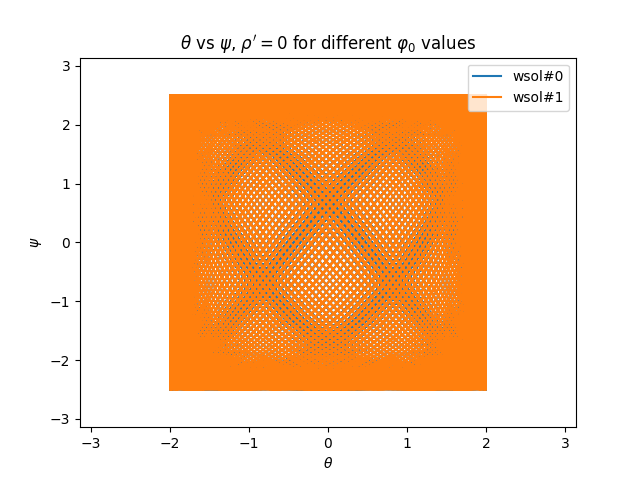

In [3]:
#when m2=0, varying the ICs of m2 does not affect the path of m1, as one would hope!
plt.close("all")
wsol1, t1, *x = sim([2,0,1.25,0,2.5,0], [0,1,0.5], stoptime=1000.0, numpoints = 5000)
wsol2, t2, *x = sim([2,0,1.75,0,2.5,0], [0,1,0.5], stoptime=1000.0, numpoints = 5000)
ani = harmAni([wsol1, wsol2], title=r"$\rho^\prime=0$ for different $φ_0$ values")
ani.save("rho=0.gif")

In [ ]:
plt.close("all")
wsol1, t1, *x = sim([.5,0,0.75,0,1,0], [.999,1,1], stoptime=10.0, numpoints = 1000)
wsol2, t2, *x = sim([.5,0,0.75,0,1,0], [.99,1,1], stoptime=10.0, numpoints = 1000)
ani = harmAni([wsol1, wsol2], title=r"$\rho^\prime=0.999 and \rho^\prime=0.99$")
ani.save("rho=ish1.gif")

In [ ]:
plt.close("all")
wsol1, t1, *x = sim([.5,0,1.25,0,1,0], [0,1,1], stoptime=50.0, numpoints = 250)
wsol2, t2, *x = sim([.5,0,1.75,0,1,0], [0,1,1], stoptime=50.0, numpoints = 250)
phasePlot(wsol1)
phasePlot(wsol2)
θtPlot(wsol1, t1)
θtPlot(wsol2, t2)

In [ ]:
plt.close("all")
wsol1, t1, *x = sim([.49,0,1.75,0,1,0], [.5,1,1], stoptime=50.0, numpoints = 250)
wsol2, t2, *x = sim([.51,0,1.75,0,1,0], [.5,1,1], stoptime=50.0, numpoints = 250) #makes a heart-shape, sort of!
ani = harmAni([wsol1, wsol2])

In [ ]:
#do not touch, it makes a heart.
plt.close("all")
wsol2, t2, *x = sim([.51,0,1.75,0,1,0], [.5,1,1], stoptime=100.0, numpoints = 1000)
ani = harmAni([wsol2])
ani.save("heartHarm.gif")

In [ ]:
#eye, ish!
plt.close("all")
wsol2, t2, *x = sim([0.5,0,0.5,0,0,0.5], [0.01,1,1], stoptime=100.0, numpoints = 1000)
ani = harmAni([wsol2], bounds=[[-1,1],[-1,1]])

In [ ]:
wsol, t, *x = sim([.5,0,1.75,0,1,0], [0,1,1], stoptime=100.0, numpoints = 1000)
phasePlot(wsol);
wsol, t, *x = sim([.5,0,1.75,0,1,0], [.05,1,1], stoptime=100.0, numpoints = 1000)
phasePlot(wsol);
wsol, t, *x = sim([.5,0,1.75,0,1,0], [.1,1,1], stoptime=100.0, numpoints = 1000)
phasePlot(wsol);

In [ ]:
wsol, t, *x = sim([.51,0,1.75,0,1,0], [.5,1,1], stoptime=1000.0, numpoints = 5000)
phasePlot(wsol, showφ=False, showψ=False);
# wsol, t, *x = sim([.5,0,1.75,0,1,0], [.5,1,1], stoptime=10.0, numpoints = 1000)
# phasePlot(wsol);

In [ ]:
plt.close("all")

In [ ]:
wsol, t, *x = sim([.5,0,2.25,0,1,0], [.5,1,1], stoptime=50.0, numpoints = 250)
ani = harmAni([wsol])

In [ ]:
wsol, t, *x = sim([.5,0,2.25,0,1,0], [.5,1,1])
# θtPlot(wsol, t)

fig1, ax1 = plt.subplots(1)
θ = wsol[:,0]
x1 = wsol[:,1]
φ = wsol[:,2]
x2 = wsol[:,3]
ψ = wsol[:,4]
x3 = wsol[:,5]
ax1.plot(θ, ψ, 'b', linewidth=1)


In [ ]:
wsol, t, *x = sim([1,0,2.25,0,1,0], [.5,1,1])
θtPlot(wsol, t)

In [ ]:
#demonstration of chaos
wsol, t, *x = sim([1,0,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)
wsol, t, *x = sim([1.01,0,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)
wsol, t, *x = sim([1.0,0.01,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)

In [ ]:
#note that the stuff from theta3 does have an effect on theta 1 and 2, but I'm
#pretty sure that this is just because of numerical error in the DE solver,
#since these very different conditions for theta 3 only show divergence in theta1
#and theta2 after like tau=50, which is comparable/even higher than how long it
#takes when I add a miniscule amt. to the theta1 or theta2 ICs.
wsol, t, *x = sim([1,0,2.25,0,1,0], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)
wsol, t, *x = sim([1,0,2.25,0,5,2], [.5,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)

In [ ]:
wsol, t, *x = sim([1,0,0,0,1.5,0], [0,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)

wsol, t, *x = sim([1,0,1,0,1.5,0], [0,1,1], stoptime=100.0, numpoints=1000)
θtPlot(wsol, t)



In [ ]:
#TODO: better captions / titles / etc on graphs

#TODO: theta1=theta; theta2=phi; theta3=psi